In [4]:
# Import some libs
from tree_test0 import numDevTotal,createTree0,createTree1
from numpy import arange
import numpy as np
from math import sqrt,ceil
from scipy.stats import norm
import matplotlib.pyplot as plt

In [13]:
#%% Step 1: Realistic hardware execution data collection
'''
          RPi	JetNano	Ultra96	  NCS GTX1060 FX6300
Cost ($)  40	    99	  250	  75	180	    70


ResNet-50 Latency (s)	FPS					﻿
Time	RaspberryPi	JetsonNano	Ultra96	  NCS	      GTX1060	  FX6300
mean	  0.479 	7.621  	34.50460762	4.587721577	26.03236414	3.733683597
std	      0.013 	0.962 	 1.1926361	0.060705309	3.373674602	0.081496673
min	 0.458068627	5.228348103	34.6740638	4.202316317	16.56973372	3.381337048
max	 0.528353566	10.25819887	34.73669585	4.797428578	37.85584494	3.930539506


Tiny Yolo3	FPS					﻿
Time	RaspberryPi	JetsonNano	Ultra96	NCS	GTX1060	FX6300
mean	0.34862538	10.44329942	43.51077173	4.203506884	16.98980166	5.935877522
std	0.008219176	0.837386835	1.848084288	0.051172827	0.592641537	1.27451256
min	0.307452117	5.724688291	37.86157807	4.070666775	12.22449054	2.991530976
max	0.39044198	14.47932353	50.1403931	4.3785521	18.2488412	4.894642813

'''
# time data
# here mu and std for devices are in unit of FPS
# Dev:	RaspberryPi	JetsonNano	Ultra96	NCS	GTX1060	FX6300
muRes = [ 0.479,7.621,34.5046,4.587,26.0323,3.733]
stdRes = [0.013,0.962,1.19,0.0607,3.37367,0.081]
muYolo = [0.3486,10.443,43.51,4.2035,16.9898,5.9358]
stdYolo = [0.0082,0.83738,1.848,0.051,0.59264,3.2745]




#power data
'''
ResNet-50 Power (Watts)	Raspberry Pi 3	Jetson Nano	Ultra96	Compute Stick(NCS)	GTX1060 6gb	FX-6300 CPU
Idle	1.8	2.2	6.2	0.4	10	72
Infer	4.8	5.6	7.6	1.9	122	145

Tiny Yolo3 Power (Watts)	Raspberry Pi 3	Jetson Nano	Ultra96	Compute Stick(NCS)	GTX1060 6gb	FX-6300 CPU
Idle	1.8	2.3	7.4	0.4	10	72
Infer	4.8	11.7	9.2	2.1	122	150
'''
idleRes = [1.8,2.2,6.2,0.4,10,72]
workRes = [4.8,5.6,7.6,1.9,122,145]

idleYolo = [1.8,2.3,7.4,0.4,10,72] 
workYolo = [4.8,11.7,9.2,2.1,122,150]

pRes = np.array([11.1756, 1.1192, 0.2618, 0.4349, 6.738, 42.766])
pYolo = np.array([15.1416, 1.4592, 0.2614, 0.5223, 7.99, 83.166])

0.2751380052534453


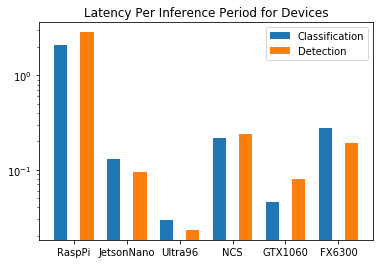

In [6]:
#%% Step 2: Latency estimation for each inference function loop(expectation)
# t_Total = t_inf + t_e2f + t_f2c

# bandwidth assumption using Wifi
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8016573
B_e2f = 135*1024/8  #135Mbps Wifi  IEEE802.11n convert to kb/s
B_f2c = 135*1024/8  #135Mbps Wifi  IEEE802.11n convert to kb/s

# S_c: size of control packet, transfer inference results
# S_dat: size of data needs to be processed,offloading from edge to fog or cloud
S_c = 1  # just assume to be 1kb, could be smaller in reality
#  image file size https://toolstud.io/photo/megapixel.php?width=640&height=480&compare=video&calculate=compressed
S_datYolo = 188    # 1280*720 JPG 100% 24bit/pixel	188 KB
S_datRes = 62.7    # 640*480
def getTimeTotal(muDevFreq,devLevel,S_c,S_dat,B_e2f,B_f2c):
    t_inf = 1/muDevFreq
    
    if devLevel==0: #highest cloud level 
        t_e2f = S_dat/B_e2f
        t_f2c = S_dat/B_f2c
            
    elif devLevel==1:
        t_e2f = S_dat/B_e2f
        t_f2c = S_c/B_f2c

    elif devLevel==2: 
        t_e2f = S_c/B_e2f
        t_f2c = S_c/B_f2c
    t_Total = t_inf + t_e2f + t_f2c
    return t_Total

print( getTimeTotal(muRes[5],0,S_c,S_datRes,B_e2f,B_f2c) )
# Dev:	RaspberryPi	JetsonNano	Ultra96	NCS	GTX1060	FX6300
# Level: 0 cloud; 1 fog; 2 edge
tRes_rpi = getTimeTotal(muRes[0],2,S_c,S_datRes,B_e2f,B_f2c)
tRes_jetnano = getTimeTotal(muRes[1],2,S_c,S_datRes,B_e2f,B_f2c)
tRes_u96 = getTimeTotal(muRes[2],2,S_c,S_datRes,B_e2f,B_f2c)
tRes_ncs = getTimeTotal(muRes[3],2,S_c,S_datRes,B_e2f,B_f2c) 
tRes_gtx1060 = getTimeTotal(muRes[4],0,S_c,S_datRes,B_e2f,B_f2c)
tRes_fx6300 = getTimeTotal(muRes[5],0,S_c,S_datRes,B_e2f,B_f2c)   

tYolo_rpi = getTimeTotal(muYolo[0],2,S_c,S_datYolo,B_e2f,B_f2c)
tYolo_jetnano = getTimeTotal(muYolo[1],2,S_c,S_datYolo,B_e2f,B_f2c)
tYolo_u96 = getTimeTotal(muYolo[2],2,S_c,S_datYolo,B_e2f,B_f2c)
tYolo_ncs = getTimeTotal(muYolo[3],2,S_c,S_datYolo,B_e2f,B_f2c) 
tYolo_gtx1060 = getTimeTotal(muYolo[4],0,S_c,S_datYolo,B_e2f,B_f2c)
tYolo_fx6300 = getTimeTotal(muYolo[5],0,S_c,S_datYolo,B_e2f,B_f2c)   

# visualization
import matplotlib.pyplot as plt

res_bars = [tRes_rpi,tRes_jetnano,tRes_u96,tRes_ncs,tRes_gtx1060,tRes_fx6300]
yolo_bars = [tYolo_rpi,tYolo_jetnano,tYolo_u96,tYolo_ncs,tYolo_gtx1060,tYolo_fx6300]

x_pos = np.arange(6)
fig, ax = plt.subplots()
ax.bar(x_pos - 0.25, res_bars, 0.25)
ax.bar(x_pos + 0.25, yolo_bars, 0.25)
ax.set_xticklabels(["RaspPi","JetsonNano","Ultra96","NCS","GTX1060","FX6300"], rotation='horizontal')
ax.set_xticks(x_pos)
plt.legend(["Classification","Detection"])
plt.semilogy()
titlestr = 'Latency Per Inference Period for Devices'
plt.title(titlestr)
plt.savefig(titlestr+'.png', dpi=300)
plt.show()  

In [7]:
#%% Step 3: Cost computation for devices: dev cost + electricity cost
#  Power estimation for 2 years cycle
#  Device cost from commercial price
'''
          RPi	JetNano	Ultra96	  NCS GTX1060 FX6300
Cost ($)  40	    99	  250	  75	180	    70

'''
devCostList = np.array([40,99,250,75,180,70])


# set electricity price as $0.1/kwh
# cycle length unit in months
def getTotalCost(devCost,devNum,pEachInf,muInTotal,lenCycle,pDevIdle):
    elecPrice = 0.1  # $0.1/kwh
    # working phase power
    total = devCost*devNum + pEachInf*muInTotal*24*30*lenCycle/1000*elecPrice
    # idle phase power
    idleRatio = 0.5
    total = total + pDevIdle*24*30*lenCycle/1000*elecPrice*idleRatio
    return total

print( getTotalCost(devCost=devCostList[5],devNum=3,pEachInf=pRes[5],muInTotal=muInAll,lenCycle=24,pDevIdle=idleRes[5]) )




#%% Batch experiments for different settings 
lenCycle = 24 # 36 months=3 years


# cv: coefficient of variance(std/mu) ==> complexity of input
cvList = [0.1,0.5,1.0,1.5,2.0]
muNum= 100    
muMax = 50 

def evalDevCost(muDevFreq,stdDevFreq,devCost,pEachInf,lenCycle,devLevel,pDevIdle):
    conf = 0.99
    
    #muNum= 100    
    #muMax = 5
    muStep = muMax/muNum
    
    cvNum = len(cvList)
    costDat = np.zeros((muNum,cvNum))
    row=0
    col=0
    for muIn in arange(muStep, muMax+muStep, muStep):
        for cV in cvList:
            #cvIn = cV            
            cloud = createTree1(inMu0=muIn,inStd0=muIn*cV)
             
            #devNum = getDevNum(muDevFreq,stdDevFreq, muIn,cvIn, conf)
            devNum = numDevTotal(muDevFreq=muDevFreq,stdDevFreq=stdDevFreq,level=devLevel,tree=cloud,conf0=conf)
            print('Num of devices:',devNum)
            costDat[row,col] = getTotalCost(devCost,devNum,pEachInf,muIn,lenCycle,pDevIdle)
            #reliaFog(N_fog,N_cam,muIn,cV,muRun,stdRun)
            col=col+1
        row=row+1
        col=0
    return costDat

costRes = np.zeros((6,muNum,5))
costYolo = np.zeros((6,muNum,5))
for i in range(6):
    devCost = devCostList[i]
    #   [RPi,JetNano,Ultra96,NCS,GTX1060,FX6300]
    if i in [0,1,2,3]:
        devLevel = 2
    else:
        devLevel = 0
    
        
    muDevFreq = muRes[i]
    stdDevFreq = stdRes[i]
    pEachInf = pRes[i]
    pDevIdle = idleRes[i]       
    costRes[i]=evalDevCost(muDevFreq,stdDevFreq,devCost,pEachInf,lenCycle,devLevel,pDevIdle)
    
    muDevFreq = muYolo[i]
    stdDevFreq = stdYolo[i]
    pEachInf = pYolo[i]
    pDevIdle = idleYolo[i]       
    costYolo[i]=evalDevCost(muDevFreq,stdDevFreq,devCost,pEachInf,lenCycle,devLevel,pDevIdle)    




1676.3013120000003
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- e

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 192
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 252
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 300
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +

Pf_edge 0.02920766724108481
Num of devices: 444
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 540
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|  

Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 348
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 516
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-

Pf_edge 0.02920766724108481
Num of devices: 444
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 660
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 876
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|  

Pf_edge 0.02920766724108481
Num of devices: 804
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1068
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1320
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1260
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1560
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 408
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
| 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 468
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 756
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1128
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |--

Pf_edge 0.02920766724108481
Num of devices: 864
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1272
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1692
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1884
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2340
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 600
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |

Pf_edge 0.02920766724108481
Num of devices: 660
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1080
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1596
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1176
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1740
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2316
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2508
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 792
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
| 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 852
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1392
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2076
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
| 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2220
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2940
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3660
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3900
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 984
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1620
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
| 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1716
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2544
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3372
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3564
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4440
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1128
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_edge 0.02920766724108481
Num of devices: 1188
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1932
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2868
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1


Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3012
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3996
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4980
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 5220
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1320
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2148
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2244
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3336
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4428
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
| 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4620
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 5760
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1452
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|

Pf_edge 0.02920766724108481
Num of devices: 6000
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 252
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 336
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Num of devices: 456
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 600
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 744
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|  

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1080
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 288
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 480
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 612
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 900
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1200
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|  

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1104
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1464
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1812
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1728
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2148
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 564
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
| 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 636
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1044
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1548
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
| 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1176
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1752
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2316
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1944
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2580
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   

Pf_edge 0.02920766724108481
Num of devices: 2844
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3552
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 912
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|

Pf_edge 0.02920766724108481
Num of devices: 3876
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 984
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1608
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1068
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1752
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2592
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2796
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3708
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4620
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4944
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1260
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2052
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1332
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2184
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3240
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
| 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3444
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4560
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 5688
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 6024
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1524
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2484
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1608
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2616
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3888
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 2748
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4092
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 5424
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4284
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 5688
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 7092
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 7416
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 1872
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3060
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 3192
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4740
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 6288
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 4932
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 6552
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 8160
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- e

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- e

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 180
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-

Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 180
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 228
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|  

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 276
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 180
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 192
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 252
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 312
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 264
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 324
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- e

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 144
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- e

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 288
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Num of devices: 228
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 300
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 372
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|  

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 144
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 144
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 180
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 192
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 180
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 228
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 144
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- e

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 204
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 252
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 264
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edg

Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- ed

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- e

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- e

Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 192
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- ed

Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 144
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 192
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|  

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 264
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Num of devices: 288
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 204
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 288
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 348
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 372
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 252
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 180
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 264
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 348
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   

Pf_edge 0.02920766724108481
Num of devices: 276
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 372
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 456
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|  

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 480
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 204
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 312
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 324
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 432
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 540
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 564
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 144
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 240
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 240
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 360
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 480
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- 

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 372
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 504
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 624
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +--

Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 12
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- e

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 36
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- e

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 192
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 228
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 60
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- e

Pf_edge 0.02920766724108481
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 180
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 228
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 252
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 312
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 84
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-

Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 336
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 144
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 96
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 228
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 240
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 324
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 408
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 348
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 432
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 108
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 120
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 192
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 288
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 300
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 396
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 492
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 516
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 132
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 216
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |--

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 144
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 228
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 336
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 348
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 468
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 576
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 492
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 612
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 156
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- 

Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 168
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 264
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 384
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- 

Pf_edge 0.02920766724108481
Num of devices: 276
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 408
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
Pf_fog 0.002509430066318874
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Pf_edge 0.02920766724108481
Num of devices: 540
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|  

Num of devices: 10
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 78.0
stdInTotal 156.0
Num of devices: 17
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 78.0
stdInTotal 234.0
Num of devices: 24
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 78.0
stdInTotal 312.0
Num of devices: 31
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fo

Num of devices: 100
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 258.0
stdInTotal 51.59999999999999
Num of devices: 15
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 258.0
stdInTotal 258.0
Num of devices: 33
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 258.0
stdInTotal 516.0
Num of devices: 57
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-

Num of devices: 93
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 426.0
stdInTotal 1278.0
Num of devices: 131
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 426.0
stdInTotal 1704.0
Num of devices: 169
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 432.0
stdInTotal 86.40000000000002
Num of devices: 25
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|  

Num of devices: 4
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 18.0
stdInTotal 36.0
Num of devices: 6
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 18.0
stdInTotal 54.0
Num of devices: 9
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 18.0
stdInTotal 72.0
Num of devices: 11
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|  

Num of devices: 113
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 192.0
stdInTotal 38.4
Num of devices: 17
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 192.0
stdInTotal 192.0
Num of devices: 38
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 192.0
stdInTotal 384.0
Num of devices: 64
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|--

    +-- edge3_2
muInTotal 360.0
stdInTotal 1080.0
Num of devices: 170
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 360.0
stdInTotal 1440.0
Num of devices: 219
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 366.0
stdInTotal 73.2
Num of devices: 32
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 366.0
stdInTotal 366.0
Num of devices: 72
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1

Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 552.0
stdInTotal 552.0
Num of devices: 109
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 552.0
stdInTotal 1104.0
Num of devices: 184
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 552.0
stdInTotal 1656.0
Num of devices: 260
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_

Num of devices: 48
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 120.0
stdInTotal 120.0
Num of devices: 107
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 120.0
stdInTotal 240.0
Num of devices: 182
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 120.0
stdInTotal 360.0
Num of devices: 257
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2


Num of devices: 262
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 294.0
stdInTotal 588.0
Num of devices: 446
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 294.0
stdInTotal 882.0
Num of devices: 629
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 294.0
stdInTotal 1176.0
Num of devices: 812
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_

Num of devices: 184
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 468.0
stdInTotal 468.0
Num of devices: 418
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 468.0
stdInTotal 936.0
Num of devices: 709
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 468.0
stdInTotal 1404.0
Num of devices: 1001
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1

Num of devices: 41
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 42.0
stdInTotal 126.0
Num of devices: 57
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 42.0
stdInTotal 168.0
Num of devices: 73
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 48.0
stdInTotal 9.6
Num of devices: 13
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2

Num of devices: 115
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 204.0
stdInTotal 408.0
Num of devices: 195
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 204.0
stdInTotal 612.0
Num of devices: 275
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 204.0
stdInTotal 816.0
Num of devices: 355
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2

    +-- edge3_2
muInTotal 384.0
stdInTotal 1152.0
Num of devices: 517
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 384.0
stdInTotal 1536.0
Num of devices: 667
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 390.0
stdInTotal 78.0
Num of devices: 97
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 390.0
stdInTotal 390.0
Num of devices: 219
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog

    +-- edge3_2
muInTotal 552.0
stdInTotal 1104.0
Num of devices: 526
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 552.0
stdInTotal 1656.0
Num of devices: 743
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 552.0
stdInTotal 2208.0
Num of devices: 959
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +-- edge0_2
|-- fog1
|   |-- edge1_0
|   |-- edge1_1
|   +-- edge1_2
|-- fog2
|   |-- edge2_0
|   |-- edge2_1
|   +-- edge2_2
+-- fog3
    |-- edge3_0
    |-- edge3_1
    +-- edge3_2
muInTotal 558.0
stdInTotal 111.59999999999998
Num of devices: 138
cloud
|-- fog0
|   |-- edge0_0
|   |-- edge0_1
|   +--

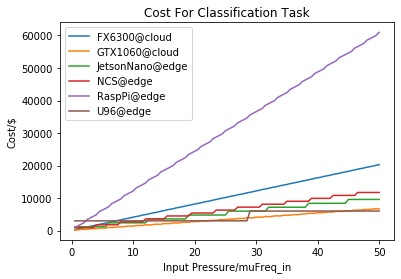

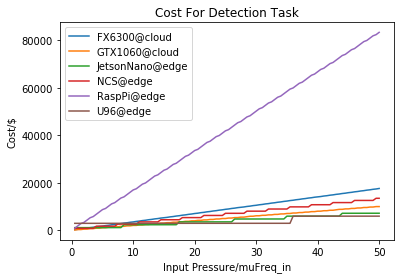

In [10]:
# set design application input complexity
# cvList = [0.1,0.5,1.0,1.5,2.0]
# very low input uncertainty
cvGoal = 0.1
cvIdx = cvList.index(cvGoal)
### draw cost plot for ResNet50 classification 
costResFX6300_cv = costRes[5,:,cvIdx]
costResGTX1060_cv = costRes[4,:,cvIdx]
costResJetNano_cv = costRes[1,:,cvIdx]
costResNCS_cv = costRes[3,:,cvIdx]
costResRpi_cv = costRes[0,:,cvIdx]
costResU96_cv = costRes[2,:,cvIdx]
#plt.figure(dpi=300)

muStep = muMax/muNum
x = arange(muStep, muMax+muStep, muStep)
plt.plot(x, costResFX6300_cv)
plt.plot(x, costResGTX1060_cv)
plt.plot(x, costResJetNano_cv)
plt.plot(x, costResNCS_cv)
plt.plot(x, costResRpi_cv)
plt.plot(x, costResU96_cv)
#titlestr = 'Cost For Classification Task With Input CV='+str(cvGoal)
titlestr = 'Cost For Classification Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'month.png', dpi=300)
plt.show()

### draw cost for TinyYolo detection


#plt.figure(dpi=300)
costYoloFX6300_cv = costYolo[5,:,cvIdx]
costYoloGTX1060_cv = costYolo[4,:,cvIdx]
costYoloJetNano_cv = costYolo[1,:,cvIdx]
costYoloNCS_cv = costYolo[3,:,cvIdx]
costYoloRpi_cv = costYolo[0,:,cvIdx]
costYoloU96_cv = costYolo[2,:,cvIdx]
#plt.figure(dpi=300)
plt.plot(x, costYoloFX6300_cv)
plt.plot(x, costYoloGTX1060_cv)
plt.plot(x, costYoloJetNano_cv)
plt.plot(x, costYoloNCS_cv)
plt.plot(x, costYoloRpi_cv)
plt.plot(x, costYoloU96_cv)
#titlestr = 'Cost For Detection Task With Input CV='+str(cvGoal)
titlestr = 'Cost For Detection Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
#plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'months.png', dpi=300)
plt.show()

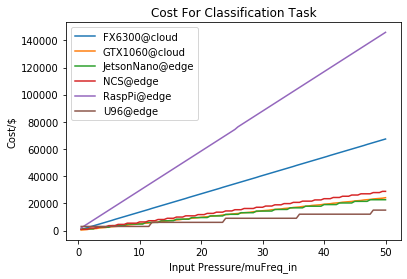

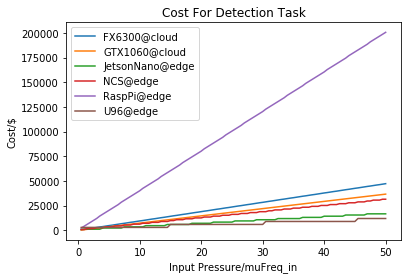

In [11]:
# set design application input complexity
# cvList = [0.1,0.5,1.0,1.5,2.0]
# medium level input uncertainty
cvGoal = 1.0
cvIdx = cvList.index(cvGoal)
### draw cost plot for ResNet50 classification 
costResFX6300_cv = costRes[5,:,cvIdx]
costResGTX1060_cv = costRes[4,:,cvIdx]
costResJetNano_cv = costRes[1,:,cvIdx]
costResNCS_cv = costRes[3,:,cvIdx]
costResRpi_cv = costRes[0,:,cvIdx]
costResU96_cv = costRes[2,:,cvIdx]
#plt.figure(dpi=300)

muStep = muMax/muNum
x = arange(muStep, muMax+muStep, muStep)
plt.plot(x, costResFX6300_cv)
plt.plot(x, costResGTX1060_cv)
plt.plot(x, costResJetNano_cv)
plt.plot(x, costResNCS_cv)
plt.plot(x, costResRpi_cv)
plt.plot(x, costResU96_cv)
#titlestr = 'Cost For Classification Task With Input CV='+str(cvGoal)
titlestr = 'Cost For Classification Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'month.png', dpi=300)
plt.show()

### draw cost for TinyYolo detection


#plt.figure(dpi=300)
costYoloFX6300_cv = costYolo[5,:,cvIdx]
costYoloGTX1060_cv = costYolo[4,:,cvIdx]
costYoloJetNano_cv = costYolo[1,:,cvIdx]
costYoloNCS_cv = costYolo[3,:,cvIdx]
costYoloRpi_cv = costYolo[0,:,cvIdx]
costYoloU96_cv = costYolo[2,:,cvIdx]
#plt.figure(dpi=300)
plt.plot(x, costYoloFX6300_cv)
plt.plot(x, costYoloGTX1060_cv)
plt.plot(x, costYoloJetNano_cv)
plt.plot(x, costYoloNCS_cv)
plt.plot(x, costYoloRpi_cv)
plt.plot(x, costYoloU96_cv)
#titlestr = 'Cost For Detection Task With Input CV='+str(cvGoal)
titlestr = 'Cost For Detection Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
#plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'months.png', dpi=300)
plt.show()

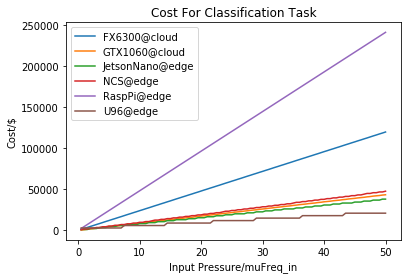

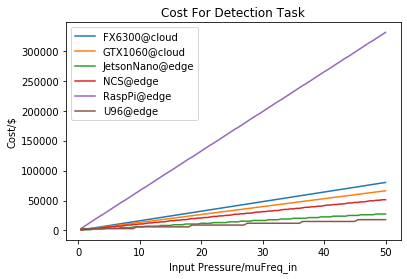

In [12]:
# set design application input complexity
# cvList = [0.1,0.5,1.0,1.5,2.0]
# relative high input uncertainty
cvGoal = 2.0
cvIdx = cvList.index(cvGoal)
### draw cost plot for ResNet50 classification 
costResFX6300_cv = costRes[5,:,cvIdx]
costResGTX1060_cv = costRes[4,:,cvIdx]
costResJetNano_cv = costRes[1,:,cvIdx]
costResNCS_cv = costRes[3,:,cvIdx]
costResRpi_cv = costRes[0,:,cvIdx]
costResU96_cv = costRes[2,:,cvIdx]
#plt.figure(dpi=300)

muStep = muMax/muNum
x = arange(muStep, muMax+muStep, muStep)
plt.plot(x, costResFX6300_cv)
plt.plot(x, costResGTX1060_cv)
plt.plot(x, costResJetNano_cv)
plt.plot(x, costResNCS_cv)
plt.plot(x, costResRpi_cv)
plt.plot(x, costResU96_cv)
#titlestr = 'Cost For Classification Task With Input CV='+str(cvGoal)
titlestr = 'Cost For Classification Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'month.png', dpi=300)
plt.show()

### draw cost for TinyYolo detection


#plt.figure(dpi=300)
costYoloFX6300_cv = costYolo[5,:,cvIdx]
costYoloGTX1060_cv = costYolo[4,:,cvIdx]
costYoloJetNano_cv = costYolo[1,:,cvIdx]
costYoloNCS_cv = costYolo[3,:,cvIdx]
costYoloRpi_cv = costYolo[0,:,cvIdx]
costYoloU96_cv = costYolo[2,:,cvIdx]
#plt.figure(dpi=300)
plt.plot(x, costYoloFX6300_cv)
plt.plot(x, costYoloGTX1060_cv)
plt.plot(x, costYoloJetNano_cv)
plt.plot(x, costYoloNCS_cv)
plt.plot(x, costYoloRpi_cv)
plt.plot(x, costYoloU96_cv)
#titlestr = 'Cost For Detection Task With Input CV='+str(cvGoal)
titlestr = 'Cost For Detection Task'
plt.title(titlestr)
plt.xlabel("Input Pressure/muFreq_in")
plt.ylabel("Cost/$")
plt.legend(['FX6300@cloud', 'GTX1060@cloud', 'JetsonNano@edge', 'NCS@edge','RaspPi@edge','U96@edge'], loc='upper left')
#plt.savefig(titlestr.replace(" ","")+'For'+str(lenCycle)+'months.png', dpi=300)
plt.show()